
## LSTM

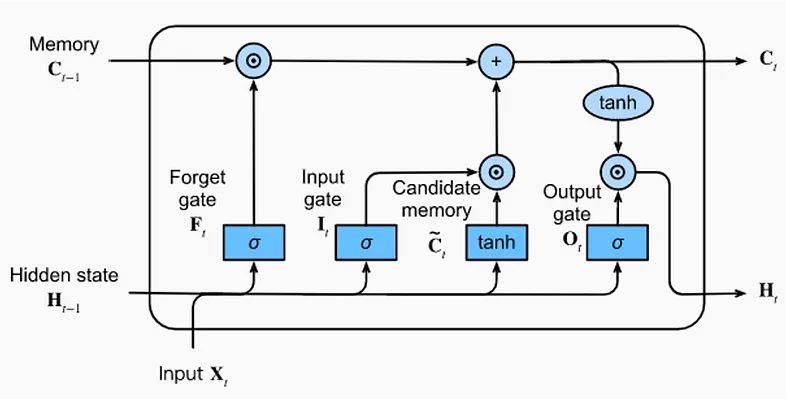

## 0) Importing libraries

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files

from sklearn.preprocessing import MinMaxScaler
import time


## 1) Importing database:




In [37]:
df = pd.read_csv('AirPassengers.csv', index_col = 0, parse_dates = True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [38]:
df.shape

(144, 1)

In [39]:
df.dropna(inplace=True)
len(df)

144

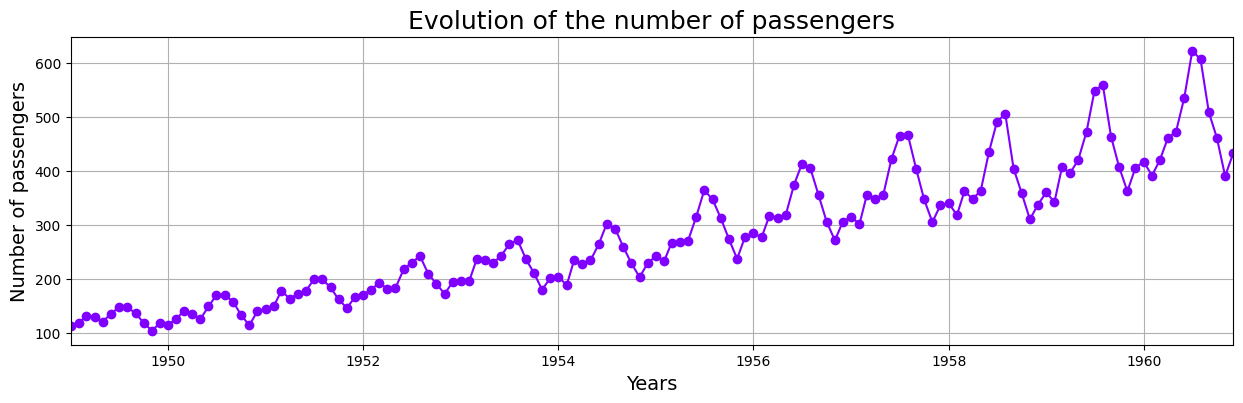

In [43]:
plt.figure(figsize = (15,4))

plt.title('Evolution of the number of passengers', fontsize=18)
plt.ylabel('Number of passengers', fontsize=14)
plt.xlabel('Years', fontsize=14)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['#Passengers'], 'o-',color='#8000ff')
plt.savefig('original_evolution_passangers.png')
plt.show()

## 2) Data processing for training and testing:

In [6]:
def processing(df, size, ws):
  #extracting the time series values
    y = df['#Passengers'].values.astype(float)

    #defining a test size
    test_size = size

    #create train and test splits
    train_set = y[:-test_size]
    test_set = y[-test_size:]
    test_set

    # instantiate a scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # normalize the training set
    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

    # convert train_norm to a tensor
    train_norm = torch.FloatTensor(train_norm).view(-1)

    # define a window size
    window_size = ws

    # convert train_norm to a tensor
    train_norm = torch.FloatTensor(train_norm).view(-1)

    out = []
    L = len(train_norm)
    for i in range(L-ws):
        window = train_norm[i:i+ws]
        label = train_norm[i+ws:i+ws+1]
        out.append((window,label))

    return out, train_norm, scaler


In [7]:
# processing parameters:

ws = 12
size = 12

In [8]:
# apply input_data to train_norm
train_data, train_norm, scaler = processing(df, size, ws)
len(train_data)

120

## 3) Building the LSTM model:




In [9]:
class LSTMnetwork(nn.Module):

    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)

        # add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)

        # initializing h0 and c0:
        self.hidden = (torch.zeros(self.num_layers, 1,self.hidden_size),
                       torch.zeros(self.num_layers, 1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

## 4) Configuring hyperparameters for the Model:

In [10]:
# Initialize the LSTM model
input_size = 1
hidden_size = 100
num_layers = 1
output_size = 1
learning_rate = 0.01
epochs = 75
#learning_rate = 0.0002
#model = LSTM(input_size, hidden_size, num_layers, output_size)

In [11]:
torch.manual_seed(42)

# instantiate
model = LSTMnetwork(input_size, hidden_size, num_layers, output_size)

# loss
criterion = nn.MSELoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

## 5) Function for model training:

In [12]:
def training_model(model, train_data, train_norm, criterion, optimizer, window_size, scaler, epochs):

    start_time = time.time()

    for epoch in range(epochs):
        for seq, y_train in train_data:
            optimizer.zero_grad()
            model.hidden = (torch.zeros(num_layers,1,model.hidden_size),
                            torch.zeros(num_layers,1,model.hidden_size))

            y_pred = model(seq)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

        print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')

        future = 12

        preds = train_norm[-window_size:].tolist()

        model.eval()

        for i in range(future):
            seq = torch.FloatTensor(preds[-window_size:])
            with torch.no_grad():
                model.hidden = (torch.zeros(num_layers,1,model.hidden_size),
                                torch.zeros(num_layers,1,model.hidden_size))
                preds.append(model(seq).item())

        preds[window_size:]

        true_predict = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

    plt.figure(figsize = (10,3))
    x = np.arange('1959-12', '1960-12', dtype='datetime64[M]').astype('datetime64[D]')
    plt.figure(figsize=(12,4))
    plt.title('evolution in the number of passengers')
    plt.ylabel('Number of passengers')
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.plot(df['#Passengers'], color='#8000ff')
    plt.plot(x, true_predict, color='#ff8000')
    plt.show()

    print(f'\nDuration: {time.time() - start_time:.0f} seconds')

    return true_predict


### Obs: Best initializing hyperparameters of LSTM to Passengers data:

#### input_size = 1
#### hidden_size = 100
#### num_layers = 1
#### output_size = 1
#### learning_rate = 0.01
#### epochs = 75

### 6) Functions for making predictions:

In [13]:
# Function to generate forecasts for later months:

def new_predict(df, model, scaler):

  # Evaluate the model
    model.eval()
    # instantiate a scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # normalize df data (full data)
    new_seq = scaler.fit_transform(np.array([df['#Passengers']]).reshape(-1, 1))

    # Necessary transformation:
    n_seq = torch.FloatTensor(new_seq)

    # Pass the data into the model in evaluation mode
    new_predict = model.forward(n_seq)

    # Normalized prediction:
    new_predict

    # Necessary transformation:
    new_predictions = new_predict.detach().cpu().numpy().reshape(-1,1)

    # Necessary transformation:
    new_predictions = scaler.inverse_transform(new_predictions.reshape(-1, 1))

    # Prediction with real scale:
    return int(new_predictions)


In [14]:
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## 7) New loop with re-training for forecasts 1961-01 until 1961-04:

In [15]:
# List with future months:
future_list = ['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01']

Epoch:  1 Loss: 0.55892467
Epoch:  2 Loss: 0.04301777
Epoch:  3 Loss: 0.00108310
Epoch:  4 Loss: 0.07177757
Epoch:  5 Loss: 0.01743316
Epoch:  6 Loss: 0.00379460
Epoch:  7 Loss: 0.02636227
Epoch:  8 Loss: 0.00155861
Epoch:  9 Loss: 0.00440187
Epoch: 10 Loss: 0.01781413
Epoch: 11 Loss: 0.02156910
Epoch: 12 Loss: 0.00172505
Epoch: 13 Loss: 0.00336777
Epoch: 14 Loss: 0.01559137
Epoch: 15 Loss: 0.00326532
Epoch: 16 Loss: 0.00035837
Epoch: 17 Loss: 0.00048558
Epoch: 18 Loss: 0.00007254
Epoch: 19 Loss: 0.03475061
Epoch: 20 Loss: 0.00001629
Epoch: 21 Loss: 0.00514266
Epoch: 22 Loss: 0.00071006
Epoch: 23 Loss: 0.00001315
Epoch: 24 Loss: 0.00075696
Epoch: 25 Loss: 0.00108391
Epoch: 26 Loss: 0.00073372
Epoch: 27 Loss: 0.00293727
Epoch: 28 Loss: 0.00398913
Epoch: 29 Loss: 0.00138423
Epoch: 30 Loss: 0.00003713
Epoch: 31 Loss: 0.00041929
Epoch: 32 Loss: 0.00111656
Epoch: 33 Loss: 0.00239197
Epoch: 34 Loss: 0.01756779
Epoch: 35 Loss: 0.00069002
Epoch: 36 Loss: 0.00856356
Epoch: 37 Loss: 0.00336233
E

<Figure size 1000x300 with 0 Axes>

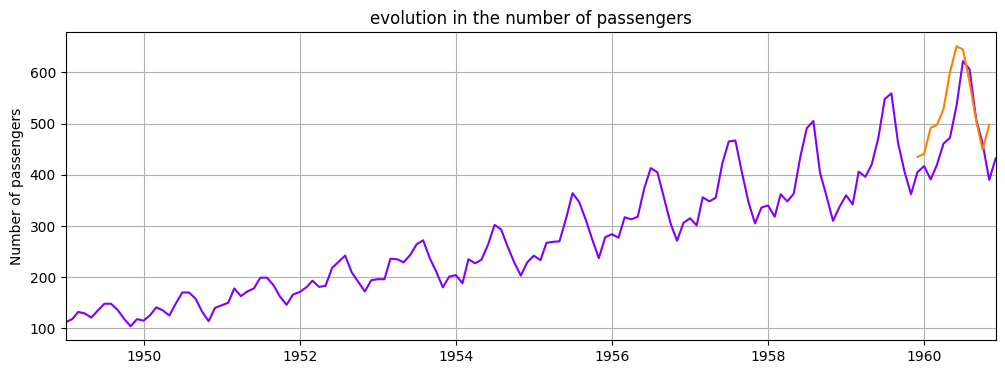


Duration: 33 seconds


<ipython-input-13-d94af6ea34b4>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(new_predictions)


Epoch:  1 Loss: 0.00087046
Epoch:  2 Loss: 0.00071410
Epoch:  3 Loss: 0.00550034
Epoch:  4 Loss: 0.00285719
Epoch:  5 Loss: 0.06940563
Epoch:  6 Loss: 0.00996848
Epoch:  7 Loss: 0.01721483
Epoch:  8 Loss: 0.00072699
Epoch:  9 Loss: 0.00030495
Epoch: 10 Loss: 0.00000003
Epoch: 11 Loss: 0.00000111
Epoch: 12 Loss: 0.00006077
Epoch: 13 Loss: 0.00033622
Epoch: 14 Loss: 0.00007780
Epoch: 15 Loss: 0.00085259
Epoch: 16 Loss: 0.00191732
Epoch: 17 Loss: 0.00197712
Epoch: 18 Loss: 0.00297876
Epoch: 19 Loss: 0.00090645
Epoch: 20 Loss: 0.00284825
Epoch: 21 Loss: 0.00001656
Epoch: 22 Loss: 0.00145727
Epoch: 23 Loss: 0.00273582
Epoch: 24 Loss: 0.00024214
Epoch: 25 Loss: 0.00002572
Epoch: 26 Loss: 0.00250391
Epoch: 27 Loss: 0.00107776
Epoch: 28 Loss: 0.00005745
Epoch: 29 Loss: 0.00034226
Epoch: 30 Loss: 0.00007201
Epoch: 31 Loss: 0.00008574
Epoch: 32 Loss: 0.01446160
Epoch: 33 Loss: 0.00253707
Epoch: 34 Loss: 0.00003169
Epoch: 35 Loss: 0.00015510
Epoch: 36 Loss: 0.00280914
Epoch: 37 Loss: 0.00320643
E

<Figure size 1000x300 with 0 Axes>

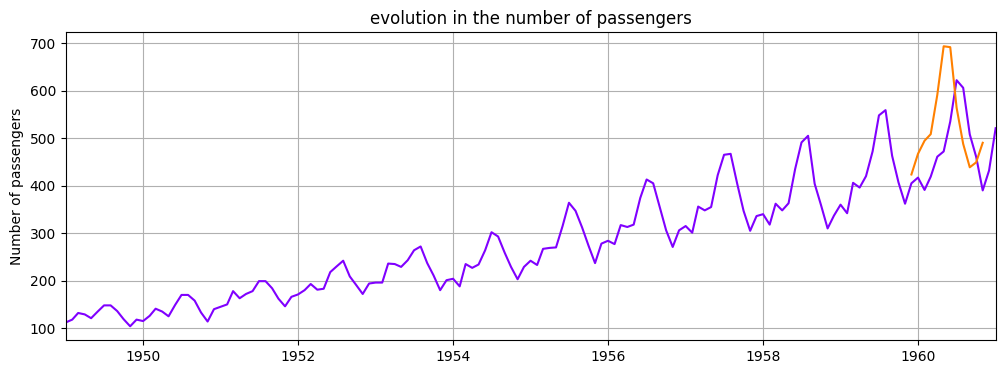


Duration: 25 seconds


<ipython-input-13-d94af6ea34b4>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(new_predictions)


Epoch:  1 Loss: 0.05314549
Epoch:  2 Loss: 0.05904694
Epoch:  3 Loss: 0.03633471
Epoch:  4 Loss: 0.01057069
Epoch:  5 Loss: 0.03766507
Epoch:  6 Loss: 0.00031649
Epoch:  7 Loss: 0.00065871
Epoch:  8 Loss: 0.02817371
Epoch:  9 Loss: 0.06666011
Epoch: 10 Loss: 0.02072854
Epoch: 11 Loss: 0.00115166
Epoch: 12 Loss: 0.00218452
Epoch: 13 Loss: 0.03669907
Epoch: 14 Loss: 0.00292511
Epoch: 15 Loss: 0.00278187
Epoch: 16 Loss: 0.00176774
Epoch: 17 Loss: 0.00174066
Epoch: 18 Loss: 0.00345902
Epoch: 19 Loss: 0.00884015
Epoch: 20 Loss: 0.00041193
Epoch: 21 Loss: 0.00002582
Epoch: 22 Loss: 0.00061579
Epoch: 23 Loss: 0.00335009
Epoch: 24 Loss: 0.01271700
Epoch: 25 Loss: 0.00076811
Epoch: 26 Loss: 0.00038839
Epoch: 27 Loss: 0.00015367
Epoch: 28 Loss: 0.00040514
Epoch: 29 Loss: 0.00004997
Epoch: 30 Loss: 0.00269376
Epoch: 31 Loss: 0.00512040
Epoch: 32 Loss: 0.03651480
Epoch: 33 Loss: 0.01766800
Epoch: 34 Loss: 0.00008679
Epoch: 35 Loss: 0.00001983
Epoch: 36 Loss: 0.00021718
Epoch: 37 Loss: 0.00430332
E

<Figure size 1000x300 with 0 Axes>

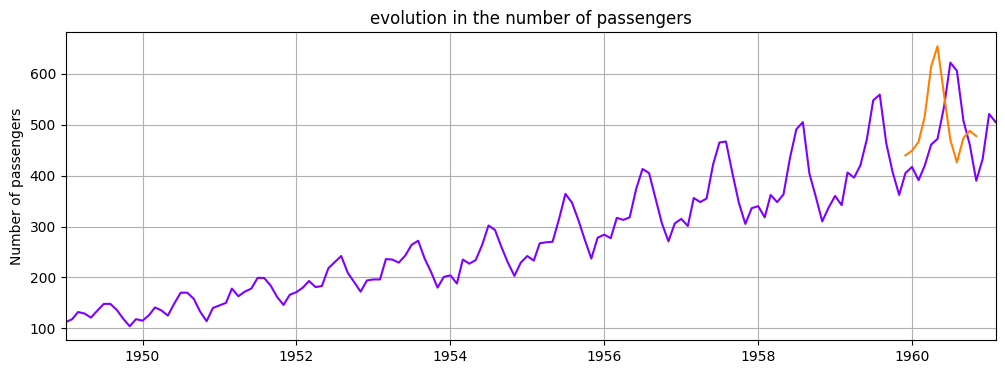


Duration: 25 seconds


<ipython-input-13-d94af6ea34b4>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(new_predictions)


Epoch:  1 Loss: 0.00361385
Epoch:  2 Loss: 0.00579174
Epoch:  3 Loss: 0.00000679
Epoch:  4 Loss: 0.00031959
Epoch:  5 Loss: 0.01053794
Epoch:  6 Loss: 0.03672305
Epoch:  7 Loss: 0.00025037
Epoch:  8 Loss: 0.00273548
Epoch:  9 Loss: 0.00421483
Epoch: 10 Loss: 0.00694806
Epoch: 11 Loss: 0.00405901
Epoch: 12 Loss: 0.00089819
Epoch: 13 Loss: 0.00177716
Epoch: 14 Loss: 0.00006959
Epoch: 15 Loss: 0.00848659
Epoch: 16 Loss: 0.00303609
Epoch: 17 Loss: 0.00077214
Epoch: 18 Loss: 0.00233266
Epoch: 19 Loss: 0.00148846
Epoch: 20 Loss: 0.00263148
Epoch: 21 Loss: 0.00007358
Epoch: 22 Loss: 0.00336992
Epoch: 23 Loss: 0.00059996
Epoch: 24 Loss: 0.00090330
Epoch: 25 Loss: 0.00002716
Epoch: 26 Loss: 0.00025274
Epoch: 27 Loss: 0.00000012
Epoch: 28 Loss: 0.01223802
Epoch: 29 Loss: 0.00348367
Epoch: 30 Loss: 0.00725486
Epoch: 31 Loss: 0.00058098
Epoch: 32 Loss: 0.00417363
Epoch: 33 Loss: 0.00023836
Epoch: 34 Loss: 0.00348155
Epoch: 35 Loss: 0.00517614
Epoch: 36 Loss: 0.00068554
Epoch: 37 Loss: 0.00253922
E

<Figure size 1000x300 with 0 Axes>

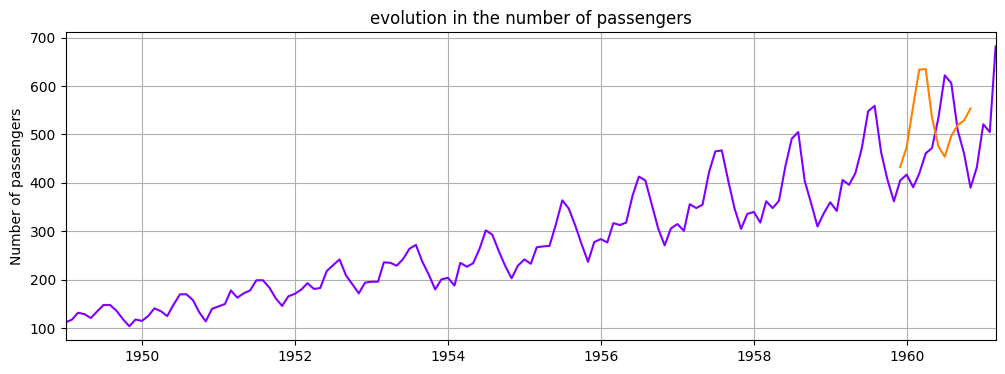


Duration: 27 seconds


<ipython-input-13-d94af6ea34b4>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(new_predictions)


In [16]:
for i in future_list:

    train_data, train_norm, scaler = processing(df, size, ws)

    true_predictions = training_model(model, train_data, train_norm, criterion, optimizer, ws, scaler, epochs)

    df.loc[i] = new_predict(df, model, scaler)




In [17]:
# Forecast for the last training:
true_predictions

array([[432.87686864],
       [473.89137545],
       [558.35683295],
       [633.76787448],
       [635.07484698],
       [534.67522451],
       [475.18466586],
       [453.93322298],
       [496.80014202],
       [519.3727819 ],
       [528.75769714],
       [553.55315575]])

In [18]:
df

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:40: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_with_columns = df.reset_index() if df.index.name else df


,#Passengers
Month,
1949-01-01 00:00:00,112
1949-02-01 00:00:00,118
1949-03-01 00:00:00,132
1949-04-01 00:00:00,129
1949-05-01 00:00:00,121
...,...
1960-12-01 00:00:00,432
1961-01-01,521
1961-02-01,505


In [19]:
df['#Passengers'][-4:]

Month
1961-01-01    521
1961-02-01    505
1961-03-01    682
1961-04-01    676
Name: #Passengers, dtype: int64

## Obs: the predict for 1961-01 is: 521 passengers!!!

### Little problems!

### Obs1: Concertar o "DeprecationWarning" quando é adicionado a previsão no banco de dados

### Obs2: Concertar o timer (00:00:00) gerado no Dataframe df

### Apesar desses alertas, o código funciona normalmente!!!

## 8) Plotting with new previsions for 1961-01 until 1961-04:

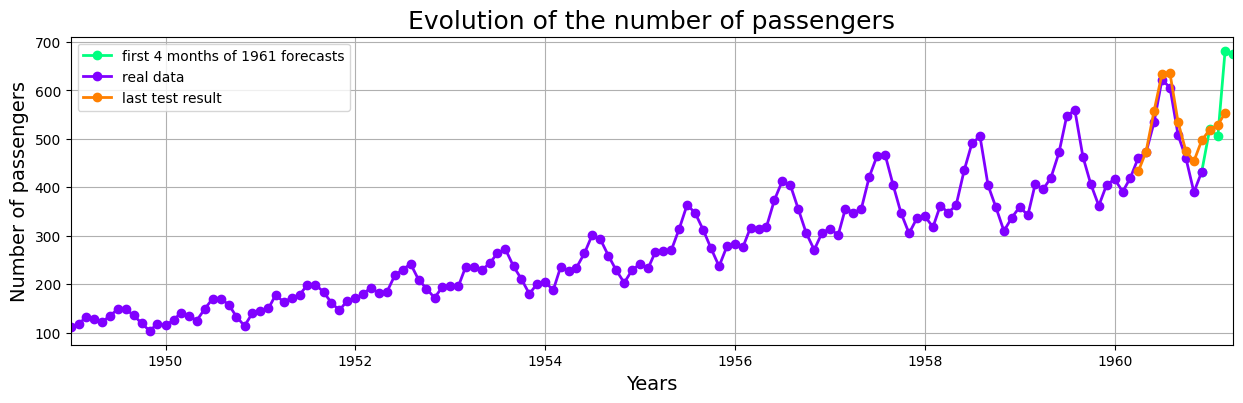

In [35]:
plt.figure(figsize = (15,4))
x = np.arange('1949-01', '1961-01', dtype='datetime64[M]').astype('datetime64[D]')
xn = np.arange('1960-12', '1961-05', dtype='datetime64[M]').astype('datetime64[D]')
xt = np.arange('1960-04', '1961-04', dtype='datetime64[M]').astype('datetime64[D]')

plt.title('Evolution of the number of passengers', fontsize=18)
plt.ylabel('Number of passengers', fontsize=14)
plt.xlabel('Years', fontsize=14)
plt.grid(True)
plt.autoscale(axis='x',tight=True)

plt.plot(xn, df['#Passengers'][-5:],'o-', color='#00FF7F',linewidth=2, label='first 4 months of 1961 forecasts')
plt.plot(x, df['#Passengers'][:-4],'o-', color='#8000ff',linewidth=2, label='real data')
plt.plot(xt,true_predictions,'o-' ,color='#ff8000',linewidth=2, label='last test result')

plt.legend()

plt.savefig('1961_4_months_prevision_passangers.png')
plt.show()


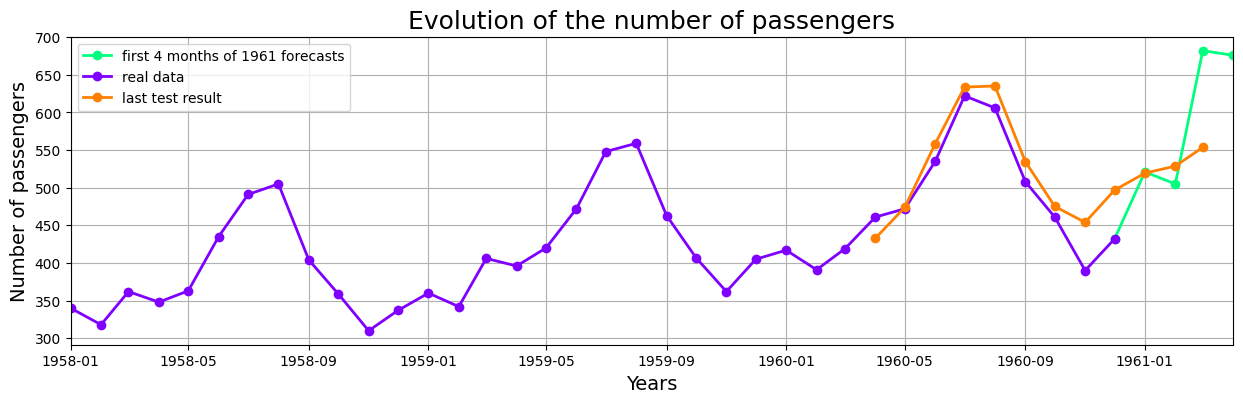

In [36]:
plt.figure(figsize = (15,4))
x = np.arange('1958-01', '1961-01', dtype='datetime64[M]').astype('datetime64[D]')
xn = np.arange('1960-12', '1961-05', dtype='datetime64[M]').astype('datetime64[D]')
xt = np.arange('1960-04', '1961-04', dtype='datetime64[M]').astype('datetime64[D]')

plt.title('Evolution of the number of passengers', fontsize=18)
plt.ylabel('Number of passengers', fontsize=14)
plt.xlabel('Years', fontsize=14)
plt.grid(True)
plt.autoscale(axis='x',tight=True)

plt.plot(xn, df['#Passengers'][-5:],'o-', color='#00FF7F',linewidth=2, label='first 4 months of 1961 forecasts')
plt.plot(x, df['#Passengers'][108:-4],'o-', color='#8000ff',linewidth=2, label='real data')
plt.plot(xt,true_predictions ,'o-', color='#ff8000',linewidth=2, label='last test result')

plt.legend()

plt.savefig('Zoom_1961_4_months_prevision_passangers.png')
plt.show()

## End